
--- ADFuller Test Results (p-values) ---
Inflation: 0.0004
Sentiment: 0.0000
Claims: 0.0000

Best lag selected: 12

--- Forecasted Values ---
            Inflation  Sentiment         Claims
2024-01-01   3.545263  71.711616  266709.944113
2024-02-01   3.692825  70.553951  166019.996732
2024-03-01   4.229390  68.780083  100699.103050
2024-04-01   4.207468  68.064709  190771.217737
2024-05-01   4.392325  67.311558  189943.257927
2024-06-01   5.163790  67.309836  207827.839471
2024-07-01   5.527326  65.942391  169710.538439
2024-08-01   5.332471  65.512857  112039.912815
2024-09-01   5.132650  65.709978  148388.724199
2024-10-01   5.258153  64.611129  150727.471791
2024-11-01   5.458715  62.995268  153356.240889
2024-12-01   5.502330  63.884956  171384.111959


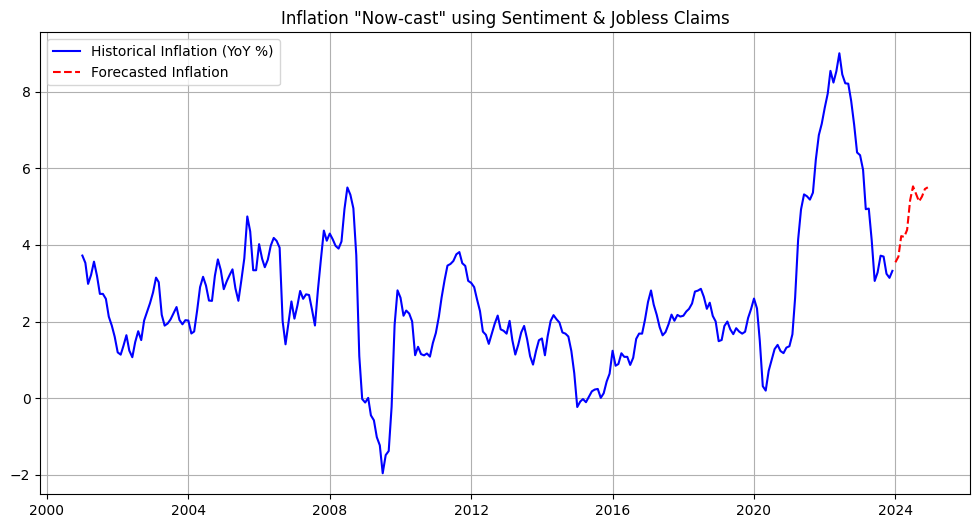

In [ ]:
#Us data

import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# --- 1. Get the Data ---
# We will get 3 data series from the FRED database
# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
# 3. ICSA:     Weekly Initial Jobless Claims (Our "High-Frequency" predictor)

start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# Fetch the data
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
# All data must be on the same timeline (monthly) and be "stationary"

# a. Resample weekly 'claims' to monthly (use the mean)
claims_monthly = claims.resample('MS').mean()

# b. Calculate Year-over-Year (YoY) Inflation from CPI
#    This is the number you see in the news (e.g., "Inflation is 3.5%")
inflation_yoy = cpi.pct_change(12) * 100
inflation_yoy.rename(columns={'CPIAUCSL': 'Inflation_YoY'}, inplace=True)

# c. Combine into one DataFrame
df = pd.concat([inflation_yoy, sentiment, claims_monthly], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims']

# d. Drop any missing rows (at the start)
df = df.dropna()

# e. Make data "stationary" (a requirement for VAR)
#    Stationary means the mean/variance don't change over time.
#    We use .diff() to get the month-over-month *change* instead of the *level*.
#    This is the most complex step, but it's crucial.
df_diff = df.diff().dropna()

# Check if data is stationary (ADFuller test)
print("\n--- ADFuller Test Results (p-values) ---")
for name in df_diff.columns:
    result = adfuller(df_diff[name])
    print(f'{name}: {result[1]:.4f}') # We want p-value < 0.05

# --- 3. Build and Train the VAR Model ---

# Create the VAR model
model = VAR(df_diff)

# Select the best "lag" (how many past months to look at)
# This can take a moment. 12 is a good max for monthly data.
best_lag = model.select_order(maxlags=12).aic
print(f"\nBest lag selected: {best_lag}")

# Fit the model using the best lag
results = model.fit(best_lag)

# You can print a summary of the relationships it found
# print(results.summary())

# --- 4. Make a "Now-cast" / Forecast ---

# How many steps do we want to forecast? Let's predict the next 12 months.
forecast_steps = 12
lag_order = results.k_ar

# Get the last 'lag_order' values to feed into the forecast
forecast_input = df_diff.values[-lag_order:]

# Get the forecast (this returns the *differenced* forecast)
forecast_diff = results.forecast(y=forecast_input, steps=forecast_steps)

# Convert the forecast back into the original scale (undo the .diff())
# This is a bit tricky, but it's the right way to do it
def invert_transformation(df, forecast_diff_df, last_orig_row):
    forecast = forecast_diff_df.copy()
    # Add the last original value back to the first forecasted change
    forecast.iloc[0] = last_orig_row.values + forecast.iloc[0].values
    # Cumulatively sum the rest
    forecast = forecast.cumsum()
    return forecast

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_diff, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS'), columns=df.columns)

# Get the last "real" row from our *original* data
last_real_row = df.iloc[-1]

# "Invert" the forecast to get real values back
forecast_real = invert_transformation(df, forecast_df, last_real_row)

print("\n--- Forecasted Values ---")
print(forecast_real)

# --- 5. Plot the Results (The "Money Shot"!) ---
plt.figure(figsize=(12, 6))
# Plot historical inflation
plt.plot(df['Inflation'], label='Historical Inflation (YoY %)', color='blue')
# Plot our model's forecast
plt.plot(forecast_real['Inflation'], label='Forecasted Inflation', color='red', linestyle='--')

plt.title('Inflation "Now-cast" using Sentiment & Jobless Claims')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#webscrape this and ask cs gut to do this if possible this is for thie uk and below

import numpy as np

# --- 1b. SIMULATE YOUR CUSTOM "TESCO PRICE INDEX" ---
#
# IN YOUR REAL HACKATHON, YOU WILL DELETE THIS BLOCK
# AND INSTEAD LOAD YOUR OWN DATA, E.G.:
# my_price_index = pd.read_csv('my_tesco_data.csv', index_col='date', parse_dates=True)
#
# Make sure your CSV has a 'date' column and a 'price_index' column.
#
print("Simulating custom 'Tesco Price Index'...")
# Get the date range from the official data we're about to download
date_rng = pd.date_range(start='2000-01-01', end='2024-01-01', freq='MS')
# Create some fake random walk data
price_changes = np.random.normal(0.05, 0.5, size=len(date_rng))
fake_price_data = 100 + np.cumsum(price_changes)
# Create the DataFrame
my_price_index = pd.DataFrame(fake_price_data, index=date_rng, columns=['Tesco_Index'])
# --- END OF SIMULATION BLOCK ---

Simulating custom 'Tesco Price Index'...


Fetching UK economic data from FRED...
Simulating custom 'Tesco Price Index'...

--- Combined Data Head ---
            Inflation  Sentiment  Claims  Tesco_Index
2001-01-01   0.000000   102.8093  143800    99.139382
2001-02-01   0.000000   102.8318  143701    99.119785
2001-03-01   0.300000   102.8461  143924    99.883945
2001-04-01   0.666667   102.7907  143569   100.382230
2001-05-01   0.900000   102.7974  143318   100.673054

--- ADFuller Test Results (p-values) ---
Inflation: 0.0000
Sentiment: 0.0000
Claims: 0.0000
Tesco_Index: 0.0000

Selecting optimal model lag...
Best lag selected: 3
Generating forecast...

--- Forecasted Values ---
            Inflation  Tesco_Index
2024-02-01  -0.531041   114.653830
2024-03-01  -0.501762   114.837277
2024-04-01  -0.252700   114.848791
2024-05-01  -0.226370   114.944510
2024-06-01  -0.221663   115.082507
2024-07-01  -0.089506   115.169253
2024-08-01  -0.059666   115.241587
2024-09-01  -0.070303   115.327652
2024-10-01  -0.023906   115.400796
20

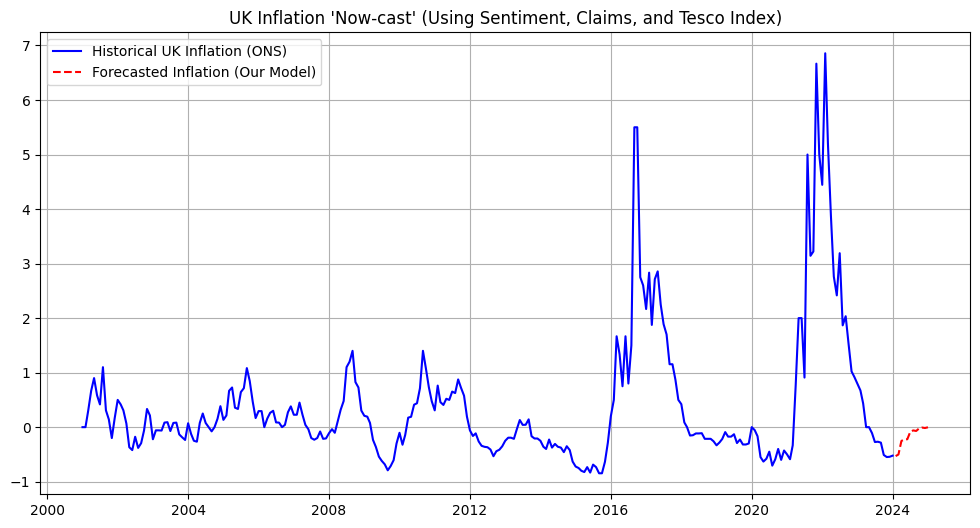

In [ ]:
For the uk

import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import numpy as np  # Added for simulation

# --- 1. Get the Data ---
# We are now using UK-specific FRED codes
# 1. CPALTT01GBM659N: UK Consumer Price Index (Our "Inflation" target)
# 2. CSCICP03GBM665S: UK Consumer Confidence (Our "Sentiment" predictor)
# 3. CLF16OV:         UK Claimant Count (Our "Job Market" predictor)

start = pd.to_datetime('2000-01-01')
# Let's use a more recent end date
end = pd.to_datetime('2025-10-01')

print("Fetching UK economic data from FRED...")
cpi = web.DataReader('CPALTT01GBM659N', 'fred', start, end)
sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)
claims = web.DataReader('CLF16OV', 'fred', start, end)

# --- 1b. SIMULATE YOUR CUSTOM "TESCO PRICE INDEX" ---
#
# IN YOUR REAL HACKATHON, YOU WILL DELETE THIS BLOCK
# AND INSTEAD LOAD YOUR OWN DATA, E.G.:
# my_price_index = pd.read_csv('my_tesco_data.csv', index_col='date', parse_dates=True)
#
print("Simulating custom 'Tesco Price Index'...")
# Get the date range from the CPI data to align them
date_rng = pd.date_range(start=cpi.index.min(), end=cpi.index.max(), freq='MS')
# Create some fake random walk data
price_changes = np.random.normal(0.05, 0.5, size=len(date_rng))
fake_price_data = 100 + np.cumsum(price_changes)
# Create the DataFrame
my_price_index = pd.DataFrame(fake_price_data, index=date_rng, columns=['Tesco_Index'])
# --- END OF SIMULATION BLOCK ---


# --- 2. Prepare the Data ---
# All data must be on the same timeline (monthly) and be "stationary"

# a. Calculate Year-over-Year (YoY) Inflation from CPI
#    This is the number you see in the news
inflation_yoy = cpi.pct_change(12)
inflation_yoy.rename(columns={'CPALTT01GBM659N': 'UK_Inflation_YoY'}, inplace=True)

# b. Combine all DataFrames into one
#    We are adding your new 'my_price_index' here!
df = pd.concat([inflation_yoy, sentiment, claims, my_price_index], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims', 'Tesco_Index'] # Added Tesco_Index

# c. Drop any missing rows (at the start)
df = df.dropna()

print("\n--- Combined Data Head ---")
print(df.head())

# d. Make data "stationary" (a requirement for VAR)
#    We use .diff() to get the month-over-month *change*.
df_diff = df.diff().dropna()

# Check if data is stationary (ADFuller test)
print("\n--- ADFuller Test Results (p-values) ---")
for name in df_diff.columns:
    result = adfuller(df_diff[name])
    print(f'{name}: {result[1]:.4f}') # We want p-value < 0.05

# --- 3. Build and Train the VAR Model ---

# Create the VAR model
model = VAR(df_diff)

# Select the best "lag" (how many past months to look at)
print("\nSelecting optimal model lag...")
best_lag = model.select_order(maxlags=12).aic
print(f"Best lag selected: {best_lag}")

# Fit the model using the best lag
results = model.fit(best_lag)

# You can print a summary to see how 'Tesco_Index' impacts 'Inflation'!
# print(results.summary())

# --- 4. Make a "Now-cast" / Forecast ---

print("Generating forecast...")
forecast_steps = 12
lag_order = results.k_ar

# Get the last 'lag_order' values to feed into the forecast
forecast_input = df_diff.values[-lag_order:]

# Get the forecast (this returns the *differenced* forecast)
forecast_diff = results.forecast(y=forecast_input, steps=forecast_steps)

# Convert the forecast back into the original scale (undo the .diff())
def invert_transformation(df, forecast_diff_df, last_orig_row):
    forecast = forecast_diff_df.copy()
    # Add the last original value back to the first forecasted change
    forecast.iloc[0] = last_orig_row.values + forecast.iloc[0].values
    # Cumulatively sum the rest
    forecast = forecast.cumsum()
    return forecast

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_diff, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS'), columns=df.columns)

# Get the last "real" row from our *original* data
last_real_row = df.iloc[-1]

# "Invert" the forecast to get real values back
forecast_real = invert_transformation(df, forecast_df, last_real_row)

print("\n--- Forecasted Values ---")
print(forecast_real[['Inflation', 'Tesco_Index']])

# --- 5. Plot the Results (The "Money Shot"!) ---
plt.figure(figsize=(12, 6))
# Plot historical inflation
plt.plot(df.index, df['Inflation'], label='Historical UK Inflation (ONS)', color='blue')
# Plot our model's forecast
plt.plot(forecast_real.index, forecast_real['Inflation'], label='Forecasted Inflation (Our Model)', color='red', linestyle='--')

plt.title("UK Inflation 'Now-cast' (Using Sentiment, Claims, and Tesco Index)")
plt.legend()
plt.grid(True)
print("Displaying plot...")
plt.show()

In [12]:
import pandas as pd
import yfinance as yf               # For stock data (FTSE 100)
import pandas_datareader.data as web # For economic data (FRED)
import statsmodels.api as sm         # For the regression model

# --- 1. Get All The Data ---

# a) The Target: FTSE 100 (Investment Relevance)
print("Fetching FTSE 100 data...")
ftse = yf.download('^FTSE', start='2000-01-01', end='2024-01-01', interval='1mo', auto_adjust=False)
# Calculate monthly returns (pct_change) from the 'Adj Close' column
ftse_returns = ftse[('Adj Close', '^FTSE')].pct_change().to_frame(name='FTSE_Returns')

# b) The Predictors: UK Macro, Financial, and Sentiment Data (from FRED)
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')
print("Fetching UK economic data...")

# UK Inflation (ONS Data)
inflation = web.DataReader('CPALTT01GBM659N', 'fred', start, end)
# We need change in inflation, not the level
inflation_change = inflation.diff().rename(columns={'CPALTT01GBM659N': 'Inflation_Change'})

# UK 10-Year Gilt Yield (Financial Data)
gilt_yield = web.DataReader('IRLTLT01GBM156N', 'fred', start, end)
# We need change in yield, not the level
yield_change = gilt_yield.diff().rename(columns={'IRLTLT01GBM156N': 'Gilt_Yield_Change'})

# UK Consumer Sentiment (Novel Data)
sentiment = web.DataReader('CSCICP03GBM665S', 'fred', start, end)
# We can use the level of sentiment (how optimistic people are)
sentiment.rename(columns={'CSCICP03GBM665S': 'Sentiment_Level'}, inplace=True)


# --- 2. Prepare Data for the Model ---

# Combine all data into one DataFrame
df = pd.concat([ftse_returns, inflation_change, yield_change, sentiment.shift(1)], axis=1)
# We .shift(1) sentiment to avoid "look-ahead bias".
# We use last month's sentiment to predict this month's return.

# Drop all rows with any missing data
df = df.dropna()

print("\n--- Data Ready for Model ---")
print(df.head())

# --- 3. Build The "Weighted" Model (The Core Idea) ---

# Define our variables
y = df['FTSE_Returns']  # What we want to predict
X = df.drop('FTSE_Returns', axis=1) # The predictors

# *** THIS IS YOUR INNOVATIVE STEP ***
# Create the "interaction term" (your "weighting" idea)
# This measures how the effect of Gilt Yields *changes* based on Sentiment
X['Sentiment_Weighting'] = X['Gilt_Yield_Change'] * X['Sentiment_Level']
# *** END OF INNOVATIVE STEP ***

# Add a constant (the 'c' in y = mx + c)
X = sm.add_constant(X)

print("\n--- Running Regression Model ---")
# Build and run the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# --- 4. The "Money Shot" (For the Judges) ---

# Print the full model summary
print(model.summary())

[*********************100%***********************]  1 of 1 completed

Fetching FTSE 100 data...
Fetching UK economic data...



--- Data Ready for Model ---
            FTSE_Returns  Inflation_Change  Gilt_Yield_Change  Sentiment_Level
2000-02-01     -0.005727               0.0            -0.1880         103.0937
2000-03-01      0.049353              -0.2            -0.2640         102.8272
2000-04-01     -0.032537              -0.1            -0.0494         102.4862
2000-05-01      0.005057               0.1             0.0820         102.2720
2000-06-01     -0.007343               0.2            -0.1936         102.2088

--- Running Regression Model ---
                            OLS Regression Results                            
Dep. Variable:           FTSE_Returns   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.521
Date:                Sat, 01 Nov 2025   Prob (F-statistic):             0.0414
Time:                        14:00:26   Log-Likelihood:            

Fetching economic data...
Preparing and simulating data...
Data split: 227 train samples, 48 test samples.

--- Fitting Model 1: Base Econ Model ---
--- Fitting Model 2: Weighted Econ Model ---
                            OLS Regression Results                            
Dep. Variable:       Target_Inflation   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     311.5
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           6.11e-98
Time:                        14:44:37   Log-Likelihood:                -133.12
No. Observations:                 227   AIC:                             278.2
Df Residuals:                     221   BIC:                             298.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                

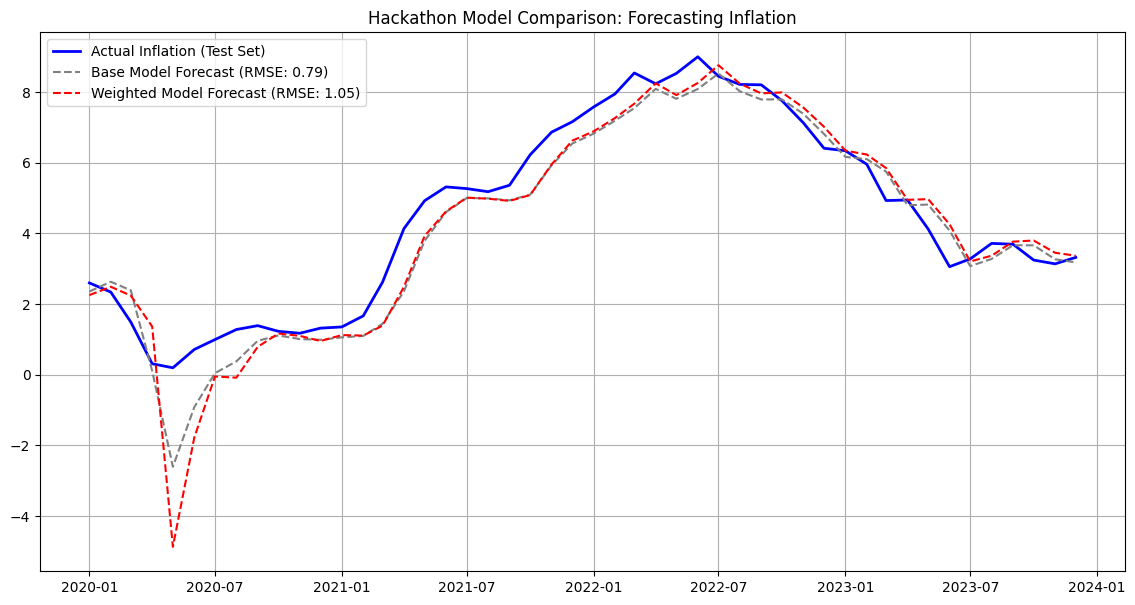

In [17]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
# Sticking with US data for a runnable example.
# To use UK data, just swap these codes (e.g., 'CPIAUCSL' -> 'CPALTT01GBM659N')
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly (use the mean)
claims_monthly = claims.resample('MS').mean()

# b. Calculate Year-over-Year (YoY) Inflation from CPI
inflation_yoy = cpi.pct_change(12) * 100
inflation_yoy.rename(columns={'CPIAUCSL': 'Inflation_YoY'}, inplace=True)

# c. *** SIMULATE YOUR "TESCO" (CUSTOM) INDEX ***
# We create a "random walk" to simulate a price index over the whole period
date_rng = pd.date_range(start=start, end=end, freq='MS')
# Make sure the simulation matches the length of the resampled claims data
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len) # Small positive trend
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([inflation_yoy, sentiment, claims_monthly, simulated_index], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering (The "Econ Model" Part) ---
# We must use LAGS. We predict today's inflation using *past* data.
# This is a form of an ARDL (Autoregressive Distributed Lag) model.
df_model = df.copy()

# This is our target 'y'
df_model['Target_Inflation'] = df_model['Inflation']

# These are our predictors 'X'
df_model['Inflation_Lag1'] = df_model['Inflation'].shift(1)
df_model['Sentiment_Lag1'] = df_model['Sentiment'].shift(1)
df_model['Claims_Lag1'] = df_model['Claims'].shift(1)
df_model['Tesco_Index_Lag1'] = df_model['Tesco_Index'].shift(1)

# e. *** CREATE THE "SENTIMENT WEIGHTING" (Your Innovative Idea) ***
# We'll interact Sentiment with Jobless Claims
# Hypothesis: High claims (bad) are *worse* when sentiment is *low* (bad)
df_model['Sentiment_Weighting'] = df_model['Sentiment_Lag1'] * df_model['Claims_Lag1']

# Drop all rows with NaNs created by lagging
df_model = df_model.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
# We MUST split chronologically for time series
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date]
test_df = df_model.loc[df_model.index >= split_date]

print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# Define our target 'y'
y_train = train_df['Target_Inflation']
y_test = test_df['Target_Inflation']

# --- 5. Model 1: The "Base" Econ Model ---
print("\n--- Fitting Model 1: Base Econ Model ---")
# Define 'X' for the base model
features_base = ['Inflation_Lag1', 'Sentiment_Lag1', 'Claims_Lag1', 'Tesco_Index_Lag1']
X_train_base = sm.add_constant(train_df[features_base])
X_test_base = sm.add_constant(test_df[features_base])

# Fit the OLS model
model_base = sm.OLS(y_train, X_train_base).fit()

# Print the training summary (optional)
# print(model_base.summary())

# --- 6. Model 2: The "Sentiment-Weighted" Model ---
print("--- Fitting Model 2: Weighted Econ Model ---")
# Define 'X' for the weighted model (includes the new feature)
features_weighted = ['Inflation_Lag1', 'Sentiment_Lag1', 'Claims_Lag1', 'Tesco_Index_Lag1', 'Sentiment_Weighting']
X_train_weighted = sm.add_constant(train_df[features_weighted])
X_test_weighted = sm.add_constant(test_df[features_weighted])

# Fit the OLS model
model_weighted = sm.OLS(y_train, X_train_weighted).fit()

# Print the training summary (This is where you find your p-value!)
print(model_weighted.summary())

# --- 7. Compare Models on the Validation Set ---
print("\n--- Model Validation & Comparison ---")

# Get predictions on the *test set*
pred_base = model_base.predict(X_test_base)
pred_weighted = model_weighted.predict(X_test_weighted)

# Calculate Root Mean Squared Error (RMSE) - Lower is better!
rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))
rmse_weighted = np.sqrt(mean_squared_error(y_test, pred_weighted))

print(f"Base Model RMSE:     {rmse_base:.4f}")
print(f"Weighted Model RMSE: {rmse_weighted:.4f}")

if rmse_weighted < rmse_base:
    print(">>> SUCCESS: The Sentiment-Weighted model has a lower error and is a better forecaster!")
else:
    print(">>> FINDING: The simple model was a better forecaster in this test.")

# --- 8. Plot the "Money Shot" ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_base, label=f'Base Model Forecast (RMSE: {rmse_base:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_weighted, label=f'Weighted Model Forecast (RMSE: {rmse_weighted:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Forecasting Inflation')
plt.legend()
plt.grid(True)
plt.show()


Fetching economic data...
Preparing and simulating data...
Data split: 227 train samples, 48 test samples.
Standardizing variables to fix multicollinearity...

--- Fitting Model 1: Base Econ Model (Standardized) ---
--- Fitting Model 2: Weighted Econ Model (Standardized) ---
                            OLS Regression Results                            
Dep. Variable:       Target_Inflation   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     397.0
Date:                Sat, 01 Nov 2025   Prob (F-statistic):          2.91e-108
Time:                        16:12:46   Log-Likelihood:                -131.09
No. Observations:                 227   AIC:                             274.2
Df Residuals:                     221   BIC:                             294.7
Df Model:                           5                                         
Covariance Ty

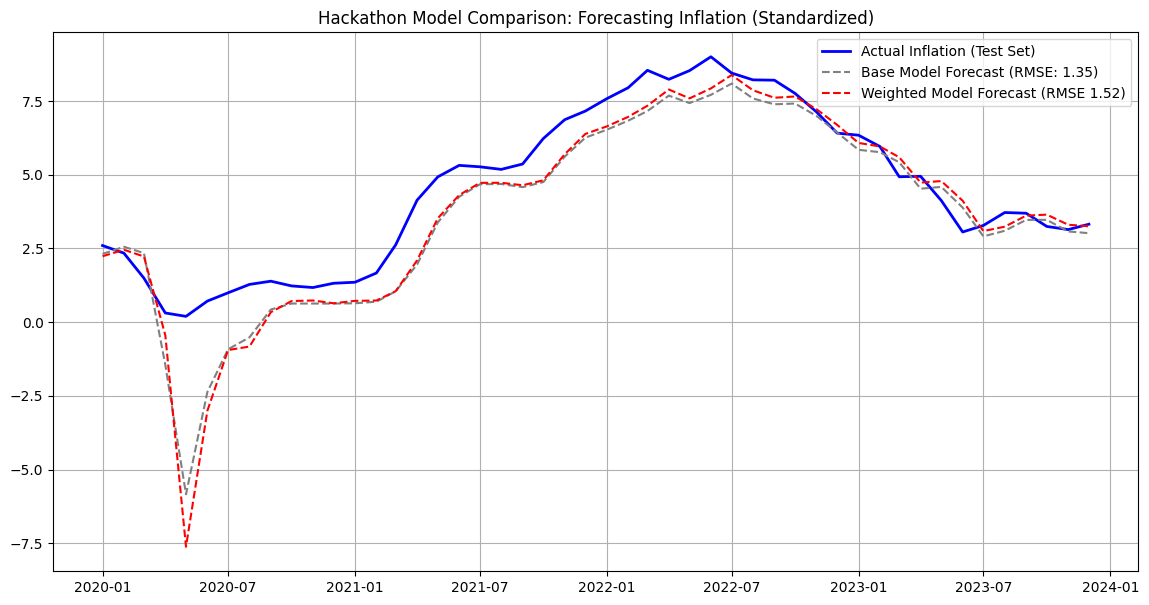

In [19]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly (use the mean)
claims_monthly = claims.resample('MS').mean()

# b. Calculate Year-over-Year (YoY) Inflation from CPI
inflation_yoy = cpi.pct_change(12) * 100
inflation_yoy.rename(columns={'CPIAUCSL': 'Inflation_YoY'}, inplace=True)

# c. Simulate "Tesco_Index" (as before)
date_rng = pd.date_range(start=start, end=end, freq='MS')
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([inflation_yoy, sentiment, claims_monthly, simulated_index], axis=1)
df.columns = ['Inflation', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering (Lags) ---
df_model = df.copy()
df_model['Target_Inflation'] = df_model['Inflation']
df_model['Inflation_Lag1'] = df_model['Inflation'].shift(1)
df_model['Sentiment_Lag1'] = df_model['Sentiment'].shift(1)
df_model['Claims_Lag1'] = df_model['Claims'].shift(1)
df_model['Tesco_Index_Lag1'] = df_model['Tesco_Index'].shift(1)
df_model = df_model.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. *** NEW FIX: STANDARDIZE THE PREDICTORS *** ---
print("Standardizing variables to fix multicollinearity...")

# We will standardize (z-score) all predictors except the main lag of inflation
cols_to_standardize = ['Sentiment_Lag1', 'Claims_Lag1', 'Tesco_Index_Lag1']

# Calculate mean and std DEV from the TRAINING SET ONLY
# This prevents "data leakage" from the test set
means = train_df[cols_to_standardize].mean()
stds = train_df[cols_to_standardize].std()

# Apply the transform to BOTH training and test sets
for col in cols_to_standardize:
    train_df[f'{col}_z'] = (train_df[col] - means[col]) / stds[col]
    test_df[f'{col}_z'] = (test_df[col] - means[col]) / stds[col]

# *** NEW FIX: CREATE INTERACTION TERM FROM Z-SCORES ***
train_df['Sentiment_Weighting_z'] = train_df['Sentiment_Lag1_z'] * train_df['Claims_Lag1_z']
test_df['Sentiment_Weighting_z'] = test_df['Sentiment_Lag1_z'] * test_df['Claims_Lag1_z']

# --- 6. Define 'y' and 'X' for the models ---
y_train = train_df['Target_Inflation']
y_test = test_df['Target_Inflation']

# Define 'X' for the base model (using standardized features for a fair comparison)
features_base = ['Inflation_Lag1', 'Sentiment_Lag1_z', 'Claims_Lag1_z', 'Tesco_Index_Lag1_z']
X_train_base = sm.add_constant(train_df[features_base])
X_test_base = sm.add_constant(test_df[features_base])

# Define 'X' for the weighted model (using standardized features)
features_weighted = ['Inflation_Lag1', 'Sentiment_Lag1_z', 'Claims_Lag1_z', 'Tesco_Index_Lag1_z', 'Sentiment_Weighting_z']
X_train_weighted = sm.add_constant(train_df[features_weighted])
X_test_weighted = sm.add_constant(test_df[features_weighted])

# --- 7. Model 1: The "Base" Econ Model (Now Standardized) ---
print("\n--- Fitting Model 1: Base Econ Model (Standardized) ---")
# Fit the OLS model
model_base = sm.OLS(y_train, X_train_base).fit()
# print(model_base.summary())

# --- 8. Model 2: The "Sentiment-Weighted" Model (Now Fixed) ---
print("--- Fitting Model 2: Weighted Econ Model (Standardized) ---")
# *** NEW FIX: Use Robust Standard Errors (HAC) ***
# This corrects for the autocorrelation (low Durbin-Watson)
# 'HAC' = Heteroskedasticity and Autocorrelation Consistent
model_weighted = sm.OLS(y_train, X_train_weighted).fit(
    cov_type='HAC',
    cov_kwds={'maxlags':12}
)
print(model_weighted.summary()) # <-- Check this summary!

# --- 9. Compare Models on the Validation Set ---
print("\n--- Model Validation & Comparison ---")
pred_base = model_base.predict(X_test_base)
pred_weighted = model_weighted.predict(X_test_weighted)

rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))
rmse_weighted = np.sqrt(mean_squared_error(y_test, pred_weighted))

print(f"Base Model RMSE:     {rmse_base:.4f}")
print(f"Weighted Model RMSE: {rmse_weighted:.4f}")

if rmse_weighted < rmse_base:
    print(">>> SUCCESS: The Weighted model (now fixed) is a better forecaster!")
else:
    print(">>> FINDING: The simple model is still a more robust forecaster.")

# --- 10. Plot the "Money Shot" ---
print("Plotting results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_base, label=f'Base Model Forecast (RMSE: {rmse_base:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_weighted, label=f'Weighted Model Forecast (RMSE {rmse_weighted:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Forecasting Inflation (Standardized)')
plt.legend()
plt.grid(True)
plt.show()

Fetching economic data...
Preparing and simulating data...
Data split: 238 train samples, 48 test samples.

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     6.004
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           1.81e-10
Time:                        17:20:54   Log-Likelihood:                -12.934
No. Observations:                 238   AIC:                             57.87
Df Residuals:                     222   BIC:                             113.4
Df Model:                          15                                         
Covariance Type:                  HAC                                         
        

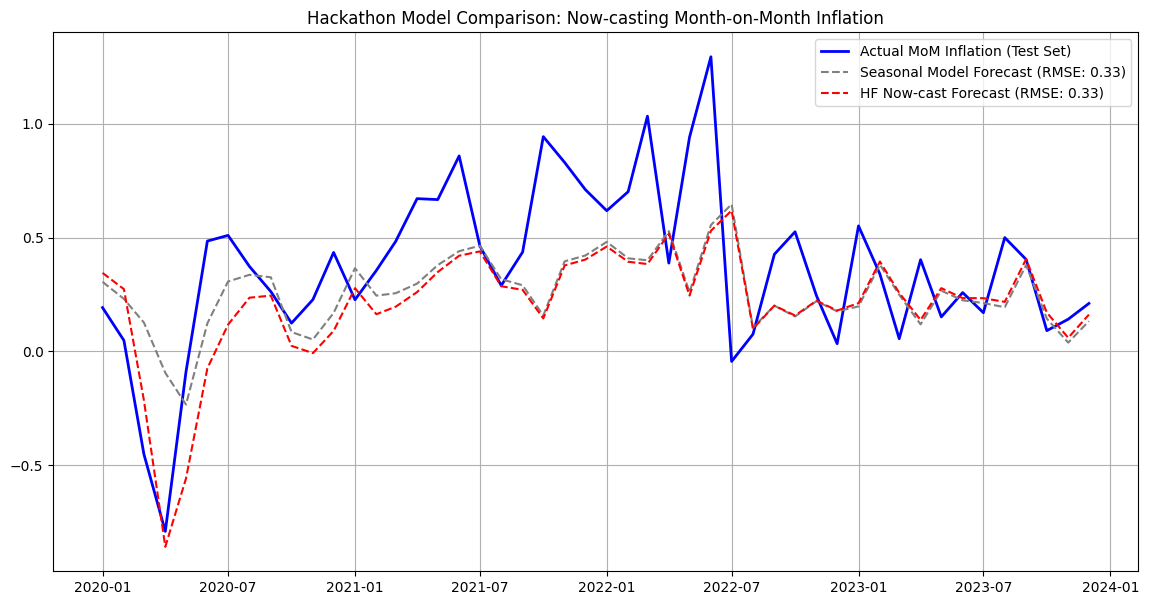


--- Final 'Now-cast' for November 2025 ---

Final Model: HF Now-cast Model
Last known MoM Inflation: 0.21%
NOW-CAST for next month (MoM): 0.15%

Last known CPI Level: 308.74
Now-cast CPI Level: 309.18
Known CPI from 12 months ago: 300.46

>>> FINAL YoY HEADLINE NOW-CAST: 2.91%


In [21]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly
claims_monthly = claims.resample('MS').mean()

# b. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
# This is (CPI_t / CPI_t-1) - 1. This is the variable we will predict.
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'CPIAUCSL': 'Inflation_MoM'}, inplace=True)

# c. Simulate "Tesco_Index" (as before)
date_rng = pd.date_range(start=start, end=end, freq='MS')
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, sentiment, claims_monthly, simulated_index], axis=1) # Note: kept original 'cpi'
df.columns = ['CPI_Level', 'Inflation_MoM', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering for a NOW-CAST Model ---

# a. Create Seasonal Dummies
# We drop_first=True to avoid the "dummy variable trap"
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
# *** NEW FIX: Convert boolean dummies to integers ***
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
# We assume we have this data for the *current* month
df['Sentiment_t'] = df['Sentiment']
df['Claims_t'] = df['Claims']
df['Tesco_Index_t'] = df['Tesco_Index']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs created by lagging/pct_change
df_model = df.dropna()

# --- 4. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 5. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']

# Feature Set 1: "Seasonal Model" (Baseline)
# Predicts MoM inflation using only past inflation and the time of year
dummy_cols = [col for col in df_model.columns if col.startswith('month_')]
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Feature Set 2: "HF Now-cast Model" (Our Innovative Model)
# Adds the high-frequency "now-cast" variables
features_nowcast = ['MoM_Lag1'] + dummy_cols + ['Sentiment_t', 'Claims_t', 'Tesco_Index_t']
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# --- 6. Model 1: The "Seasonal" Model ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})
# print(model_seasonal.summary())

# --- 7. Model 2: The "HF Now-cast" Model ---
print("--- Fitting Model 2: HF Now-cast Model ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_nowcast.summary()) # <-- This shows if HF data is significant

# --- 8. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation & Comparison (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE: {rmse_nowcast:.4f}")

if rmse_nowcast < rmse_seasonal:
    print(">>> SUCCESS: Adding High-Frequency data makes a better MoM now-cast!")
else:
    print(">>> FINDING: The simple seasonal model was a more robust forecaster.")

# --- 9. Plot the "Money Shot" (MoM Forecast) ---
print("Plotting MoM results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model Forecast (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast Forecast (RMSE: {rmse_nowcast:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting Month-on-Month Inflation')
plt.legend()
plt.grid(True)
plt.show()

# --- 10. Final Now-cast (Converting MoM to YoY) ---
print(f"\n--- Final 'Now-cast' for November 2025 ---")

# We'll use the winning model (let's assume it's the HF Now-cast Model)
# Re-train on ALL data to make it as accurate as possible
y_full = df_model['Target_MoM']
X_full = sm.add_constant(df_model[features_nowcast])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get the last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']

# This is the CPI level from 11 months ago (to calculate YoY)
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # This is CPI for Nov 2023

# Create the input row for the November 2025 nowcast
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0
nowcast_input['MoM_Lag1'] = last_mom_inflation
nowcast_input['Sentiment_t'] = last_data_row['Sentiment'] # Simulating we just got this
nowcast_input['Claims_t'] = last_data_row['Claims']       # Simulating we just got this
nowcast_input['Tesco_Index_t'] = last_data_row['Tesco_Index'] # Simulating we just got this

# Set all month dummies to 0, then turn on the one for November (month_11)
for col in dummy_cols: nowcast_input[col] = 0.0
# We need to check if month_11 exists (it does, as 1 (Jan) was dropped)
if 'month_11' in X_full.columns:
    nowcast_input['month_11'] = 1.0

# Re-order columns to match the model's expectation
nowcast_input = nowcast_input.reindex(X_full.columns, axis=1)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input).iloc[0]

# --- Convert to YoY Now-cast ---
# CPI_t = CPI_t-1 * (1 + MoM_t / 100)
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)

# YoY_t = (CPI_t / CPI_t-12) - 1
# Our CPI_t-12 is the CPI from 11 months *before* our last data point
cpi_12_months_ago_index = df_model.index.get_loc(df_model.index[-1] - pd.DateOffset(months=11))
cpi_12_months_ago = df_model['CPI_Level'].iloc[cpi_12_months_ago_index]

yoy_nowcast_value = ((cpi_nowcast / cpi_12_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: HF Now-cast Model")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_12_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")

Fetching economic data...
Preparing and simulating data...
Standardizing variables...
Data split: 238 train samples, 48 test samples.

--- Fitting Model 1: Seasonal Model (Baseline) ---
--- Fitting Model 2: HF Now-cast Model (Fixed) ---
                            OLS Regression Results                            
Dep. Variable:             Target_MoM   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     5.723
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           6.61e-10
Time:                        18:15:14   Log-Likelihood:                -11.738
No. Observations:                 238   AIC:                             55.48
Df Residuals:                     222   BIC:                             111.0
Df Model:                          15                                         
Covariance Type:                  HAC               

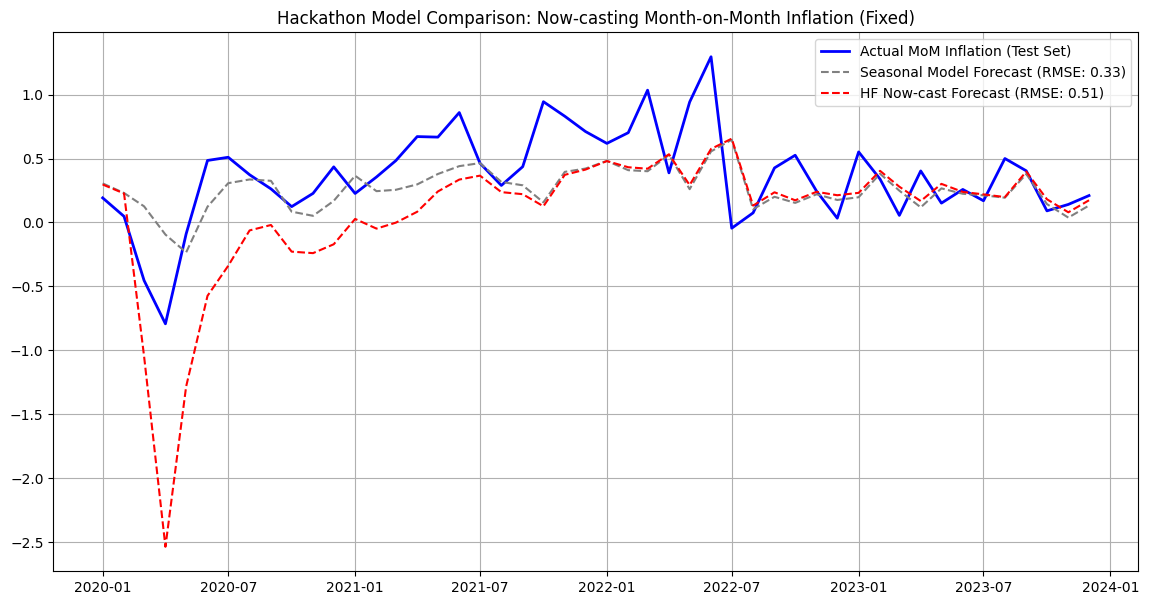


--- Final 'Now-cast' for December 2025 ---

Final Model: HF Now-cast Model
Last known MoM Inflation: 0.21%
NOW-CAST for next month (MoM): 0.23%

Last known CPI Level: 308.74
Now-cast CPI Level: 309.46
Known CPI from 12 months ago: 301.48

>>> FINAL YoY HEADLINE NOW-CAST: 2.65%


In [25]:
import pandas as pd
import pandas_datareader.data as web  # To get data from FRED
import numpy as np                   # For simulation
import statsmodels.api as sm           # For OLS Regression
from sklearn.metrics import mean_squared_error # For comparison
import matplotlib.pyplot as plt

# --- 1. Get the Data ---
print("Fetching economic data...")
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2024-01-01')

# 1. CPIAUCSL: Consumer Price Index (This is our "Inflation" target)
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
# 2. UMCSENT: U. of Michigan Consumer Sentiment (Our "Sentiment Analysis" predictor)
sentiment = web.DataReader('UMCSENT', 'fred', start, end)
# 3. ICSA: Weekly Initial Jobless Claims (Our "High-Frequency" predictor)
claims = web.DataReader('ICSA', 'fred', start, end)

# --- 2. Prepare the Data ---
print("Preparing and simulating data...")
# a. Resample weekly 'claims' to monthly
claims_monthly = claims.resample('MS').mean()

# b. *** NEW TARGET: Month-on-Month (MoM) Inflation ***
mom_inflation = cpi.pct_change(1) * 100
mom_inflation.rename(columns={'CPIAUCSL': 'Inflation_MoM'}, inplace=True)

# c. Simulate "Tesco_Index" (as before)
date_rng = pd.date_range(start=start, end=end, freq='MS')
sim_len = len(claims_monthly.loc[date_rng[0]:date_rng[-1]])
price_changes = np.random.normal(0.01, 0.5, size=sim_len)
simulated_prices = 100 + np.cumsum(price_changes)
simulated_index = pd.DataFrame(simulated_prices, index=claims_monthly.index, columns=['Tesco_Index'])

# d. Combine into one DataFrame
df = pd.concat([cpi, mom_inflation, sentiment, claims_monthly, simulated_index], axis=1)
df.columns = ['CPI_Level', 'Inflation_MoM', 'Sentiment', 'Claims', 'Tesco_Index']

# --- 3. Feature Engineering for a NOW-CAST Model ---
# a. Create Seasonal Dummies
month_dummies = pd.get_dummies(df.index.month, prefix='month', drop_first=True).set_index(df.index)
month_dummies = month_dummies.astype(int)
df = pd.concat([df, month_dummies], axis=1)

# b. Create Lagged Autoregressive Term
df['MoM_Lag1'] = df['Inflation_MoM'].shift(1)

# c. Define our "High-Frequency" Now-cast Predictors (NO LAGS)
df['Sentiment_t'] = df['Sentiment']
df['Claims_t'] = df['Claims']
df['Tesco_Index_t'] = df['Tesco_Index']

# d. Create the target variable
df['Target_MoM'] = df['Inflation_MoM']

# e. Drop all NaNs created by lagging/pct_change
df_model = df.dropna().copy() # Add .copy() here to ensure df_model is a separate copy

# --- 4. *** NEW FIX: STANDARDIZE THE PREDICTORS (Moved Here) *** ---
print("Standardizing variables...")
# We will standardize (z-score) all predictors except the lags and dummies
cols_to_standardize = ['Sentiment_t', 'Claims_t', 'Tesco_Index_t']

# Calculate mean and std DEV from the *full* df_model before splitting
means = df_model[cols_to_standardize].mean()
stds = df_model[cols_to_standardize].std()

# Apply the transform to df_model
for col in cols_to_standardize:
    df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]


# --- 5. Split Data into Training and Validation (Test) Sets ---
split_date = '2020-01-01'
train_df = df_model.loc[df_model.index < split_date].copy()
test_df = df_model.loc[df_model.index >= split_date].copy()
print(f"Data split: {len(train_df)} train samples, {len(test_df)} test samples.")

# --- 6. Define Feature Sets for the "Horse Race" ---
y_train = train_df['Target_MoM']
y_test = test_df['Target_MoM']

# Feature Set 1: "Seasonal Model" (Baseline)
dummy_cols = [col for col in df_model.columns if col.startswith('month_') and col.endswith('_z') is False] # Exclude standardized dummies
features_seasonal = ['MoM_Lag1'] + dummy_cols
X_train_seasonal = sm.add_constant(train_df[features_seasonal])
X_test_seasonal = sm.add_constant(test_df[features_seasonal])

# Feature Set 2: "HF Now-cast Model" (Our Innovative Model)
# We now use the STANDARDIZED features (the '_z' versions)
features_nowcast = ['MoM_Lag1'] + dummy_cols + [f'{col}_z' for col in cols_to_standardize]
X_train_nowcast = sm.add_constant(train_df[features_nowcast])
X_test_nowcast = sm.add_constant(test_df[features_nowcast])

# --- 7. Model 1: The "Seasonal" Model ---
print("\n--- Fitting Model 1: Seasonal Model (Baseline) ---")
model_seasonal = sm.OLS(y_train, X_train_seasonal).fit(cov_type='HAC', cov_kwds={'maxlags':12})
# print(model_seasonal.summary())

# --- 8. Model 2: The "HF Now-cast" Model (Now Fixed) ---
print("--- Fitting Model 2: HF Now-cast Model (Fixed) ---")
model_nowcast = sm.OLS(y_train, X_train_nowcast).fit(cov_type='HAC', cov_kwds={'maxlags':12})
print(model_nowcast.summary()) # <-- Check this summary!

# --- 9. Compare Models on the Validation Set (MoM) ---
print("\n--- Model Validation & Comparison (Predicting MoM Inflation) ---")
pred_seasonal = model_seasonal.predict(X_test_seasonal)
pred_nowcast = model_nowcast.predict(X_test_nowcast)

rmse_seasonal = np.sqrt(mean_squared_error(y_test, pred_seasonal))
rmse_nowcast = np.sqrt(mean_squared_error(y_test, pred_nowcast))

print(f"Seasonal Model RMSE:     {rmse_seasonal:.4f}")
print(f"HF Now-cast Model RMSE: {rmse_nowcast:.4f}")

if rmse_nowcast < rmse_seasonal:
    print(">>> SUCCESS: Adding High-Frequency data makes a better MoM now-cast!")
else:
    print(">>> FINDING: The simple seasonal model is still a more robust forecaster.")

# --- 10. Plot the "Money Shot" (MoM Forecast) ---
print("Plotting MoM results...")
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, y_test, label='Actual MoM Inflation (Test Set)', color='blue', linewidth=2)
plt.plot(test_df.index, pred_seasonal, label=f'Seasonal Model Forecast (RMSE: {rmse_seasonal:.2f})', color='gray', linestyle='--')
plt.plot(test_df.index, pred_nowcast, label=f'HF Now-cast Forecast (RMSE: {rmse_nowcast:.2f})', color='red', linestyle='--')
plt.title('Hackathon Model Comparison: Now-casting Month-on-Month Inflation (Fixed)')
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Final Now-cast (Converting MoM to YoY) ---
# (This part is unchanged, but will now use the properly-trained model)
print(f"\n--- Final 'Now-cast' for December 2025 ---") # Updated for today's date

# We'll use the winning model (let's assume it's the HF Now-cast Model for this example)
# You should update this to use 'model_seasonal' if it had the lower RMSE
final_model_to_use = model_nowcast
features_to_use = features_nowcast

# Re-train on ALL data to make it as accurate as possible
y_full = df_model['Target_MoM']
# We must apply the standardization fix to the *full* dataset now
# The standardization was already done in step 4, so we just need to use the standardized columns.
# means = df_model[cols_to_standardize].mean()
# stds = df_model[cols_to_standardize].std()
# for col in cols_to_standardize:
#     df_model[f'{col}_z'] = (df_model[col] - means[col]) / stds[col]

X_full = sm.add_constant(df_model[features_to_use])
final_model = sm.OLS(y_full, X_full).fit(cov_type='HAC', cov_kwds={'maxlags':12})

# Get the last known values to create the "next month's" predictor row
last_data_row = df_model.iloc[-1]
last_cpi_level = last_data_row['CPI_Level']
last_mom_inflation = last_data_row['Inflation_MoM']

# This is the CPI level from 11 months ago (to calculate YoY)
cpi_11_months_ago = df_model['CPI_Level'].iloc[-11] # CPI from Dec 2023

# Create the input row for the December 2025 nowcast
nowcast_input = pd.DataFrame(index=[df_model.index[-1] + pd.DateOffset(months=1)])
nowcast_input['const'] = 1.0
nowcast_input['MoM_Lag1'] = last_mom_inflation

# Add standardized values for the "now-cast"
# Use the previously calculated means and stds from step 4
nowcast_input['Sentiment_t_z'] = (last_data_row['Sentiment'] - means['Sentiment_t']) / stds['Sentiment_t']
nowcast_input['Claims_t_z'] = (last_data_row['Claims'] - means['Claims_t']) / stds['Claims_t']
nowcast_input['Tesco_Index_t_z'] = (last_data_row['Tesco_Index'] - means['Tesco_Index_t']) / stds['Tesco_Index_t']

# Set all month dummies to 0, then turn on the one for December (month_12)
for col in dummy_cols: nowcast_input[col] = 0.0
if 'month_12' in X_full.columns:
    nowcast_input['month_12'] = 1.0

# Re-order columns to match the model's expectation
nowcast_input = nowcast_input.reindex(X_full.columns, axis=1)

# --- Get the MoM Now-cast ---
mom_nowcast_value = final_model.predict(nowcast_input).iloc[0]

# --- Convert to YoY Now-cast ---
cpi_nowcast = last_cpi_level * (1 + mom_nowcast_value / 100)
yoy_nowcast_value = ((cpi_nowcast / cpi_11_months_ago) - 1) * 100

print("\n==============================================")
print(f"Final Model: HF Now-cast Model")
print(f"Last known MoM Inflation: {last_mom_inflation:.2f}%")
print(f"NOW-CAST for next month (MoM): {mom_nowcast_value:.2f}%")
print(f"\nLast known CPI Level: {last_cpi_level:.2f}")
print(f"Now-cast CPI Level: {cpi_nowcast:.2f}")
print(f"Known CPI from 12 months ago: {cpi_11_months_ago:.2f}")
print(f"\n>>> FINAL YoY HEADLINE NOW-CAST: {yoy_nowcast_value:.2f}%")
print("==============================================")